### Cat's vrs Dogs Transfare learning
Our goal in this notebook is to be able to use the `keras.application` api to do transfare learning using `tfds` cats vs dogs dataset.

### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
train = tfds.load('cats_vs_dogs', split="train")

> We are only going to work with `100` images for training and `50` images of validating and `10` images of test.

In [3]:
train_images = np.array([i['image'] for i in train])
train_labels = np.array([i['label'] for i in train])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


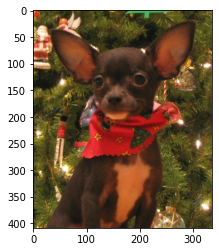

In [4]:
plt.imshow(train_images[1])

In [5]:
train_images = np.array([tf.image.resize(i.numpy().astype('float32')/255, size=(100, 100)) for i in train_images[:171]])

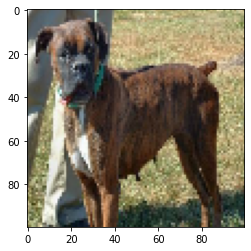

In [10]:
plt.imshow(train_images[0])

In [41]:
X_train = train_images[:100]
y_train = train_labels[:100]

X_valid = train_images[100:150]
y_valid = train_labels[100:150]


X_test = train_images[150:171]
y_test = train_labels[150:171]

> Let's create a simple `model` to fit on this data.

In [43]:
model = keras.Sequential([
    keras.layers.Input(shape=(100, 100, 3)),
    keras.layers.Conv2D(16, (2, 2), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(128, (2, 2), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (2, 2), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
   loss = keras.losses.BinaryCrossentropy(),
    optimizer = 'adam',
    metrics=['acc']
) 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 99, 99, 16)        208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 128)       8320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 64)        32832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 16)       

In [44]:
early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 3,
    verbose = 0
)

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
          verbose=1, batch_size=10, callbacks =[early_stoping])

Epoch 1/10
10/10 [==============================] - 1s 29ms/step - loss: 0.7039 - acc: 0.5679 - val_loss: 0.7083 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6636 - acc: 0.5967 - val_loss: 0.6873 - val_acc: 0.5000
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6681 - acc: 0.6110 - val_loss: 0.6849 - val_acc: 0.5000
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6579 - acc: 0.6063 - val_loss: 0.6899 - val_acc: 0.5000
Epoch 5/10
10/10 [==============================] - 0s 12ms/step - loss: 0.6772 - acc: 0.5592 - val_loss: 0.6721 - val_acc: 0.5200
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6433 - acc: 0.5757 - val_loss: 0.6991 - val_acc: 0.5000
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.5906 - acc: 0.6303 - val_loss: 0.6540 - val_acc: 0.6600
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.5983 - a

> Evaluating the model

In [45]:
y_test.shape, X_train.shape

((21,), (100, 100, 100, 3))

In [46]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 228ms/step - loss: 0.7597 - acc: 0.4286


[0.7597278356552124, 0.4285714328289032]

### Transfare learning

We want to use a pretrained model to **fine tune** the last layer of the pretrained model to be able to do our classification task.


**Fine Tunning**: involves not touching or retraining the earlier layers in our convolutional base but only adjusting the final few. We do this because the first layers in our base are very good at extracting low level featureslines and edges, things that are similar for any kind of image. Where the later layers are better at picking up very specific features like shapes or even eyes. If we adjust the final layers than we can look for only features relevant to our very specific problem in our case the `Binary` classification of dog or a cat.

> 🎈 [Docs Ref](https://www.tensorflow.org/tutorials/images/transfer_learning)

We will create the base model from the ``MobileNet V2`` model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify ``cats`` and ``dogs`` from our specific dataset.

First, we need to pick which layer of `` MobileNet V2`` you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the ``"bottleneck layer"``. The ``bottleneck layer ``features retain more generality as compared to the final/top layer.

First, instantiate a`` MobileNet V2`` model pre-loaded with weights trained on ImageNet. By specifying the ``include_top=False`` argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [47]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(100, 100, 3),
                                               include_top=False,
                                               weights='imagenet')

In [48]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 50, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

**Freeze the convolutional base:** 
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

```python
base_model.trainable = False
```

In [49]:
base_model.trainable = False
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 99, 99, 16)        208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 128)       8320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 64)        32832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 16)       

### Important note about BatchNormalization layers
Many models contain ``tf.keras.layers.BatchNormalization`` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set ``layer.trainable = False``, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing ``training = False`` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

### Adding our Classifier
Now that we have our base layer setup, we can add the classifier. Instead of flattening the feature map of the base layer we will use a ``global average pooling`` layer.

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Adding the output layer

In [51]:
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### Now we are ready to create a new model.
Creating a new model in our case using transfare learning is the art of adding all these three layers together which are:
* base_model
* global_average_layer
* output_layer
.. together

In [52]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  output_layer
])
# compile the model

model.compile(
    loss = keras.losses.binary_crossentropy,
    optimizer = keras.optimizers.RMSprop(),
    metrics=['acc']
)

### Now we can fit the model on our data.

In [53]:
early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 3,
    verbose = 0
)

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid),
          verbose=1, batch_size=10, callbacks =[early_stoping])

Epoch 1/10
10/10 [==============================] - 3s 100ms/step - loss: 0.7007 - acc: 0.6265 - val_loss: 0.2811 - val_acc: 0.9000
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2654 - acc: 0.9282 - val_loss: 0.2513 - val_acc: 0.9200
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2076 - acc: 0.9109 - val_loss: 0.2290 - val_acc: 0.9200
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.1405 - acc: 0.9765 - val_loss: 0.2392 - val_acc: 0.9200
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0897 - acc: 0.9776 - val_loss: 0.2748 - val_acc: 0.9200
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0685 - acc: 1.0000 - val_loss: 0.2026 - val_acc: 0.8800
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0505 - acc: 1.0000 - val_loss: 0.2038 - val_acc: 0.9200
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0480 - 

> Before evaluating the model, we can be able to see that our model had imporoved from as interms of `accuracy` as compared to the previous model

In [54]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.3257 - acc: 0.8095


[0.325657457113266, 0.8095238208770752]

> Our model is now `80%` accurate on the test data.

> Making `predictions`

In [67]:
class_names = np.array(["cat", "dog"])

In [63]:
predictions = tf.squeeze(tf.round(model.predict(X_test)))

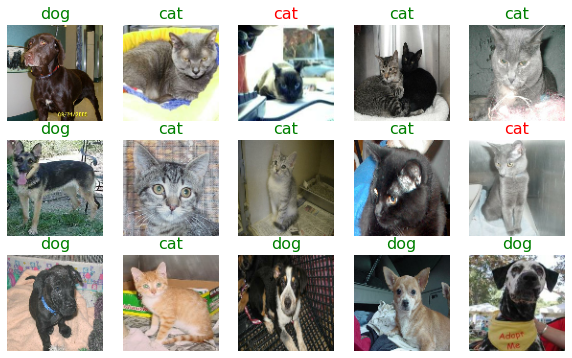

In [78]:
def plot_predictions_images(images_and_classes, labels_true, labels_pred, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true, labels_pred)):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(class_names[label_true], color ='g' if label_true == label_pred else 'r', fontsize=16 )

plot_predictions_images(X_test[:15], y_test[:15], predictions[:15])

In [65]:
predictions, y_test

(<tf.Tensor: shape=(21,), dtype=float32, numpy=
 array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0.], dtype=float32)>,
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]))

> Plotting the ``Confusion matrix``

In [76]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=16): 
      # Create the confustion matrix
      cm = confusion_matrix(y_true, y_pred)
      cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
      n_classes = cm.shape[0]
      # Plot the figure and make it pretty
      fig, ax = plt.subplots(figsize=figsize)
      cax = ax.matshow(cm, cmap=plt.cm.Blues) 
      fig.colorbar(cax)
    
      if classes:
        labels = classes
      else:
        labels = np.arange(cm.shape[0])
        
      ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="True label",
             xticks=np.arange(n_classes),
             yticks=np.arange(n_classes), 
             xticklabels=labels,
             yticklabels=labels)

      ax.xaxis.set_label_position("bottom")
      ax.xaxis.tick_bottom()

      threshold = (cm.max() + cm.min()) / 2.
      # Plot the text on each cell
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

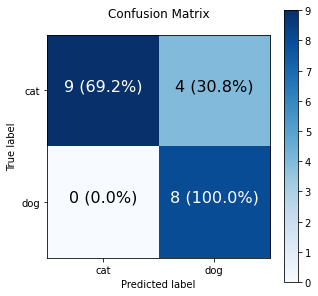

In [77]:
plot_confusion_matrix(y_test, predictions, list(class_names))

> **Conclusion:** - Transfare learning is a very powerfull machine learning technique that allows us to use pretrained models which were trainned on huge amound of dataset, to fit in our small model by just twicking few layers. As we can see we were able to make accurate predictions, with the model which used a pretrained model as it's base mode.

### References
* [Cats vrs Dogs Dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)
* [Machine Learning Mastery](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)

### Next
* [Object Detection](https://github.com/tensorflow/models/tree/master/research/object_detection)